/var/folders/j1/p6dqnbb11ll9tbzx1mn_r4fh0000gn/T/ipykernel_10580/1382408797.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True)


           ra        dec  u_mag  g_mag  r_mag  i_mag  z_mag  Err_u  Err_g  \
0  180.502959  40.501279  22.19  22.67  22.29  21.62  21.24   0.35   0.22   
1  180.489991  40.495756  24.39  23.99  22.68  21.64  21.62   1.30   0.55   
2  180.512484  40.503784  23.78  20.67  19.14  17.91  17.30   0.87   0.03   
3  180.491587  40.509986  25.61  22.53  22.38  21.98  21.63   0.85   0.15   
4  180.496867  40.488860  22.47  21.73  21.01  20.88  20.00   0.39   0.09   

   Err_r  Err_i  Err_z  
0   0.23   0.20   0.41  
1   0.26   0.15   0.45  
2   0.01   0.01   0.01  
3   0.19   0.18   0.42  
4   0.06   0.08   0.12  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17650 entries, 0 to 17649
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ra      17650 non-null  float64
 1   dec     17650 non-null  float64
 2   u_mag   17650 non-null  float64
 3   g_mag   17650 non-null  float64
 4   r_mag   17650 non-null  float64
 5   i_mag   17650 

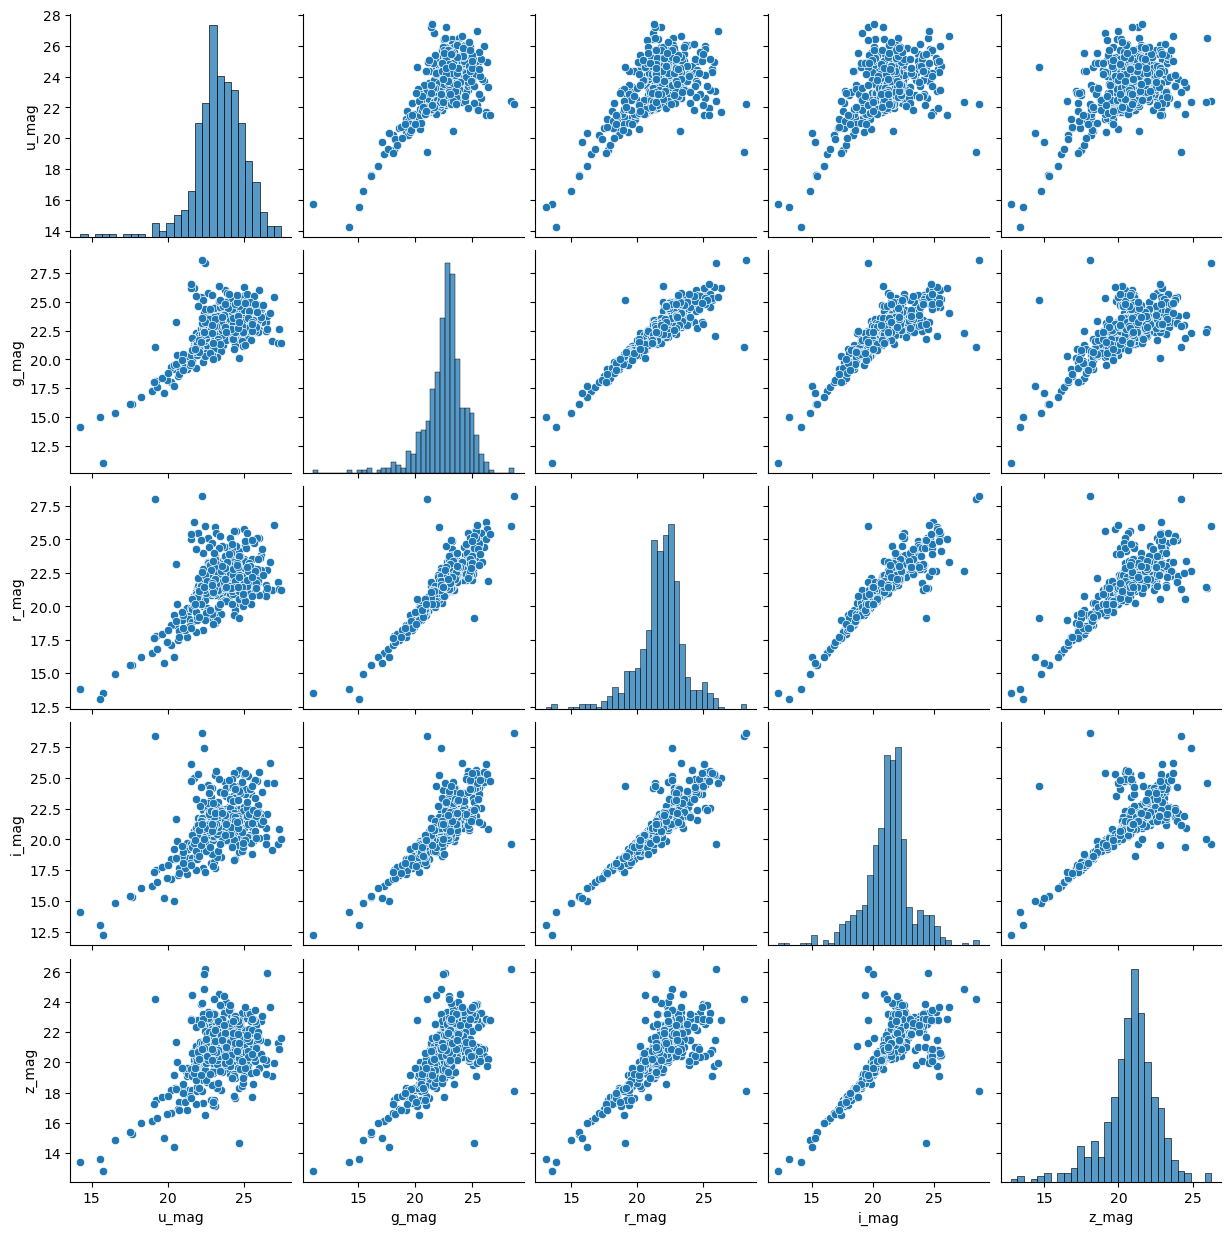

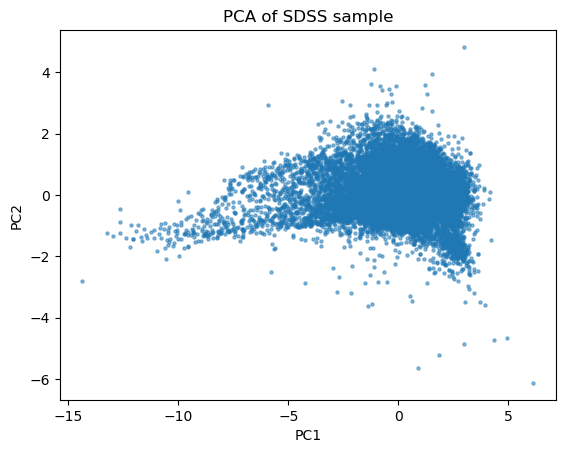

Explained variance ratio: [0.77708316 0.12365807]


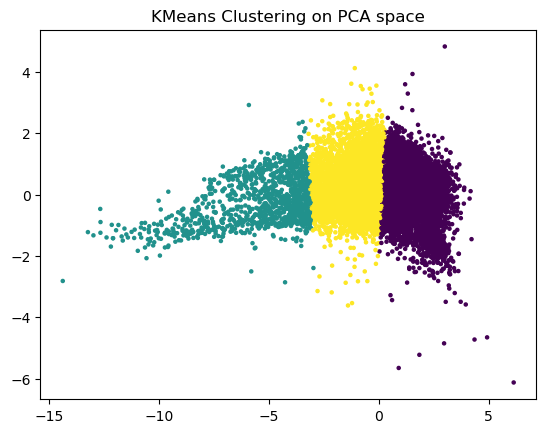

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3062
           1       0.99      0.98      0.99       685
           2       0.96      0.96      0.96      1548

    accuracy                           0.97      5295
   macro avg       0.98      0.97      0.98      5295
weighted avg       0.97      0.97      0.97      5295



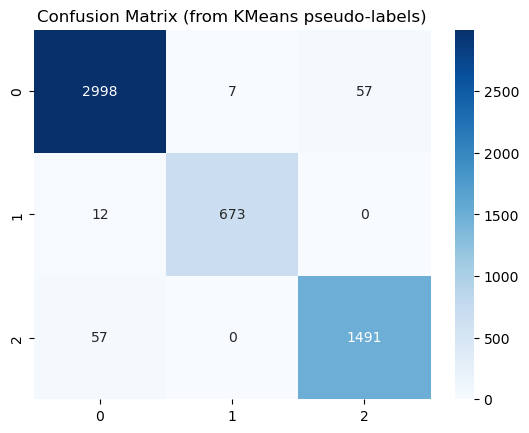


1. 聚类分析：聚类分析是一种无监督学习方法，它不依赖于事先的类别标签。自动把样本分为若干类（此次作业中将其分为3类），让同一类的样本在特征空间中尽可能接近。这里我们输入的特征是：[u_mag, g_mag, r_mag, i_mag, z_mag, Err_u, Err_g, Err_r, Err_i, Err_z]。结果理解：得到的 class 列（0, 1, 2）是算法自动划分的类别。它可能代表在颜色-星等空间中的三种典型天体群体，比如：
	•	一类可能是颜色较红、光度较弱的星系；
	•	一类可能是颜色较蓝的恒星；
	•	一类可能是颜色极端、可能为类星体（QSO）的天体。
	•	不同类之间在色指数上的分布差异，可以揭示天体的辐射能谱差异，即不同的能量分布和物理过程。
2. 监督学习（分类模型）。监督学习依赖于已知标签，模型通过这些样本学习到“输入特征 → 类别”的映射。我们使用的是随机森林（RandomForestClassifier），一种基于决策树集成的算法。在作业中，我们用 KMeans 的伪标签做“监督学习演示”；在真实天体数据中，可以用 SDSS 的 spectroscopic class（例如 STAR、GALAXY、QSO）作为标签。结果理解：训练好的模型通过特征（多波段星等及误差）预测天体类别。
3. PCA 主成分分析：PCA 是一种线性降维方法，用于找出数据中最主要的变化方向（主成分）。它通过线性组合特征，使得：第 1 主成分解释最多方差；第 2 主成分解释次多方差；以此类推。结果理解：PCA 可以帮助我们发现哪些特征变化最重要。如：
	•	若第 1 主成分主要由 u_mag, g_mag 权重较高，说明短波段的亮度差异最能区分天体；
	•	若第 2 主成分受 Err_i, Err_z 影响大，可能说明长波段观测误差是另一个主变化方向。
	•	通过绘制 PCA 前两主成分散点图（彩色标记不同类别），可验证：
	•	聚类或分类结果是否与数据结构一致；
	•	类别是否在主成分空间中明显分离。
4. 天体物理意义：
    PCA 是探索性分析工具，可帮助理解光谱或颜色特征的内在规律：
	1.	发现主要能谱变化方向（例如恒星温度或星系红移主导的趋势）；
	2.	特征降维：减少噪声，提取核心物理量（如颜色指数组合）；
	3.	光谱特征压缩：在光谱

In [43]:
# SDSS 天体物理统计项目

# --- 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. 数据读取与初步探索 ---
file_path = "SDSS_17K.dat"
#df = pd.read_csv(file_path, sep='|')  # 根据实际情况调整分隔符
df = pd.read_csv(file_path, delim_whitespace=True)

print(df.head())
print(df.info())

# --- 2. 数据清洗 ---
# 去除缺失值
df = df.dropna()

# 选择主要物理量（例如光度、颜色指标、红移等）
features = ['u_mag', 'g_mag', 'r_mag', 'i_mag', 'z_mag']  # 请根据实际列名调整
X = df[features]

# --- 3. 描述性统计与可视化 ---
print(X.describe())
sns.pairplot(X.sample(500))
plt.show()

# --- 4. PCA 分析 ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], s=5, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of SDSS sample")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

# --- 5. 聚类分析 ---
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=5)
plt.title("KMeans Clustering on PCA space")
plt.show()

# --- 6. 监督学习（分类模型） ---
# 假设存在 object_class 列（如 QSO, STAR, GALAXY）
# --- 特征选择 ---
X = df[['u_mag', 'g_mag', 'r_mag', 'i_mag', 'z_mag', 'Err_u', 'Err_g', 'Err_r', 'Err_i', 'Err_z']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 使用无监督聚类生成“伪标签” ---
kmeans = KMeans(n_clusters=3, random_state=42)
df['class'] = kmeans.fit_predict(X_scaled)

# --- 监督学习（使用聚类标签作为分类目标）
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (from KMeans pseudo-labels)")
plt.show()
#if 'class' in df.columns:
#    y = df['class']
#    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#    clf = RandomForestClassifier(n_estimators=100, random_state=42)
#    clf.fit(X_train, y_train)
#    y_pred = clf.predict(X_test)

#    print(classification_report(y_test, y_pred))
#    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
#    plt.title("Confusion Matrix")
#    plt.show()

# --- 7. 小结与讨论 ---
# 学生可在此部分写出对比不同方法结果的理解和天体物理意义
print("""
1. 聚类分析：聚类分析是一种无监督学习方法，它不依赖于事先的类别标签。自动把样本分为若干类（此次作业中将其分为3类），让同一类的样本在特征空间中尽可能接近。这里我们输入的特征是：[u_mag, g_mag, r_mag, i_mag, z_mag, Err_u, Err_g, Err_r, Err_i, Err_z]。结果理解：得到的 class 列（0, 1, 2）是算法自动划分的类别。它可能代表在颜色-星等空间中的三种典型天体群体，比如：
	•	一类可能是颜色较红、光度较弱的星系；
	•	一类可能是颜色较蓝的恒星；
	•	一类可能是颜色极端、可能为类星体（QSO）的天体。
	•	不同类之间在色指数上的分布差异，可以揭示天体的辐射能谱差异，即不同的能量分布和物理过程。
2. 监督学习（分类模型）。监督学习依赖于已知标签，模型通过这些样本学习到“输入特征 → 类别”的映射。我们使用的是随机森林（RandomForestClassifier），一种基于决策树集成的算法。在作业中，我们用 KMeans 的伪标签做“监督学习演示”；在真实天体数据中，可以用 SDSS 的 spectroscopic class（例如 STAR、GALAXY、QSO）作为标签。结果理解：训练好的模型通过特征（多波段星等及误差）预测天体类别。
3. PCA 主成分分析：PCA 是一种线性降维方法，用于找出数据中最主要的变化方向（主成分）。它通过线性组合特征，使得：第 1 主成分解释最多方差；第 2 主成分解释次多方差；以此类推。结果理解：PCA 可以帮助我们发现哪些特征变化最重要。如：
	•	若第 1 主成分主要由 u_mag, g_mag 权重较高，说明短波段的亮度差异最能区分天体；
	•	若第 2 主成分受 Err_i, Err_z 影响大，可能说明长波段观测误差是另一个主变化方向。
	•	通过绘制 PCA 前两主成分散点图（彩色标记不同类别），可验证：
	•	聚类或分类结果是否与数据结构一致；
	•	类别是否在主成分空间中明显分离。
4. 天体物理意义：
    PCA 是探索性分析工具，可帮助理解光谱或颜色特征的内在规律：
	1.	发现主要能谱变化方向（例如恒星温度或星系红移主导的趋势）；
	2.	特征降维：减少噪声，提取核心物理量（如颜色指数组合）；
	3.	光谱特征压缩：在光谱或时序数据中提取主要模式。
    监督学习（分类模型）监督学习用于光学颜色分类，在大规模巡天中具有重要应用：
	1.	恒星/星系分离（Star/Galaxy Separation）：基于多波段颜色和形态参数；
	2.	类星体识别（QSO Identification）：替代光谱分辨率较低的情况下的初筛；
	3.	恒星类型判别：区分白矮星、红巨星、主序星等；
	4.	快速分类：在没有光谱的情况下，直接从成千上万天体的光度信息中推断类别。
    聚类分析常用于发现未知类型或边缘类型的天体。
""")
